## STOCK PREDICTION BY DEEP LEARNING MODEL
딥러닝 수업 과제로 베낄 수 밖에 없었던 코드들을 천천히 공부해볼 예정입니다.


In [13]:
import warnings
warnings.filterwarnings("ignore")
#경고 메세지 무시

In [19]:
import time
import numpy as np
import pandas as pd

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score

#라이브러리 불러오기
#각 라이브러리에 대한 설명은 필요할 때 하겠읍니다..

In [16]:
context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(1719)
#MXNET : 아마존에서 만든 딥 러닝 플랫폼. 구글의 텐서플로우와 비슷.
#mx.cpu() : 사용할 CPU 지정. default=0
#random.seed() : 난수 생성을 위한 seed 설정. 뭘 넣어도 상관없는듯

## data crawling
주가 데이터 수집. 추후 다른 데이터도 가져올 예정

In [38]:
code_KR = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13', header=0)[0]
code_KRs = code_KR[['회사명', '종목코드']]
code_KRs = code_KRs.rename(columns={'회사명' : 'name', '종목코드' : 'code' })
code_KRs.code = code_KRs.code.map('{:06d}'.format)
#한국증권거래소에서 주식회사와 종목코드 가져오기

In [39]:
code_KRs.head() #상위 5개 목록 보여줌

,name,code
0,DSR,155660
1,GS글로벌,001250
2,HSD엔진,082740
3,LG이노텍,011070
4,OCI,010060


In [40]:
def get_url(item_name, code_df):
    code = code_df.query("name=='{}'".format(item_name))['code'].to_string(index=False)
    url = "http://finance.naver.com/item/sise_day.nhn?code={code}".format(code=code)
    print("요청 URL = {}".format(url))
    return url

#네이버 주식에서 해당 회사의 url 가져오기

In [41]:

item_name ='삼성전자'
url = get_url(item_name, code_KRs)
url = url.replace(" ", "")
df = pd.DataFrame()

for page in range(1, 50):
    pg_url = '{url}&page={page}'.format(url = url, page = page)
    df = df.append(pd.read_html(pg_url, header=0)[0], ignore_index=True)
    
    
df = df.dropna()

df.head()

#삼성전자 주식 가격을 가져오자

요청 URL = http://finance.naver.com/item/sise_day.nhn?code= 005930


,날짜,종가,전일비,시가,고가,저가,거래량
1,2020.01.08,57200.0,1400.0,56200.0,57200.0,55900.0,14612580.0
2,2020.01.07,55800.0,300.0,55700.0,56400.0,55600.0,10009778.0
3,2020.01.06,55500.0,0.0,54900.0,55600.0,54600.0,10278951.0
4,2020.01.03,55500.0,300.0,56000.0,56600.0,54900.0,15422255.0
5,2020.01.02,55200.0,600.0,55500.0,56000.0,55000.0,12993228.0


In [44]:
samsung = df[['날짜', '종가']]
samsung_end = samsung.rename(columns = {'날짜' : 'date', '종가' : 'price'})

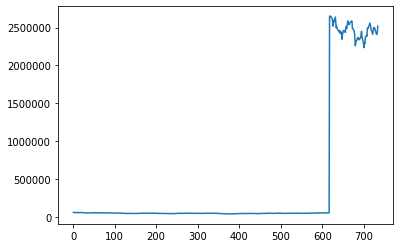

In [47]:
plt.plot(samsung_end['price']) ##아 삼성전자 주식 분할을 생각못했네